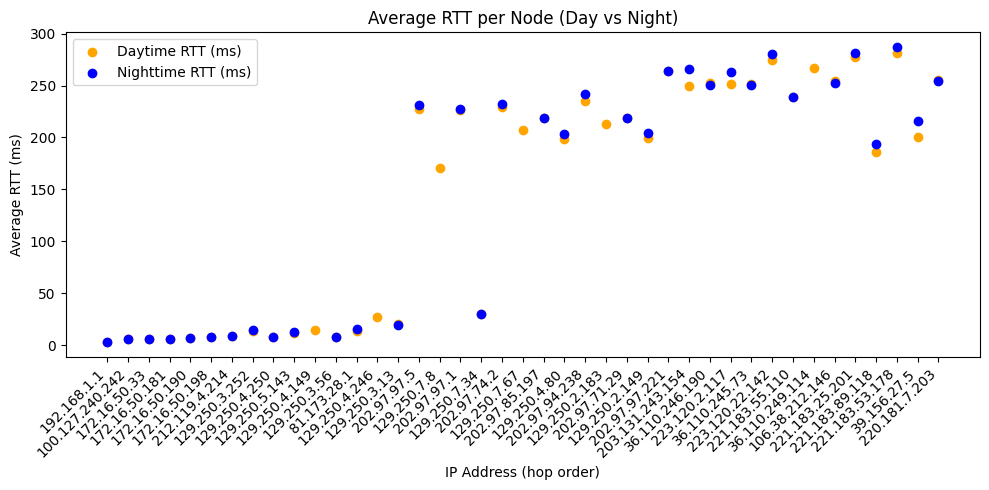

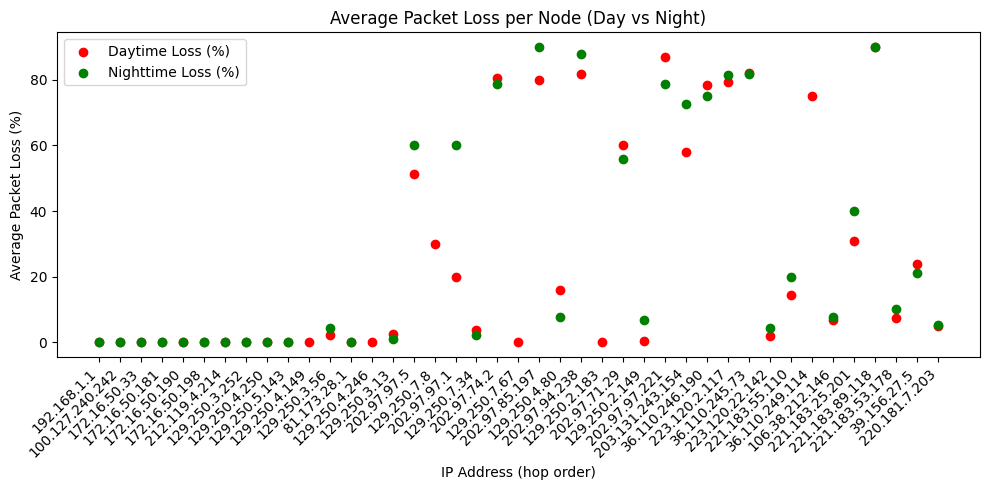

In [2]:
import json
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

# ====== 文件路径 ======
FILE_NAME = "reports.json"

# ====== 加载数据 ======
with open(FILE_NAME, "r") as f:
    data = json.load(f)

# ====== 初始化字典 ======
stats = {
    "day": {"rtt_sum": defaultdict(float), "rtt_count": defaultdict(int),
            "loss_sum": defaultdict(float), "loss_count": defaultdict(int),
            "order": {}},
    "night": {"rtt_sum": defaultdict(float), "rtt_count": defaultdict(int),
              "loss_sum": defaultdict(float), "loss_count": defaultdict(int),
              "order": {}}
}

# ====== 判定昼夜函数（英国时区）======
def is_nighttime(hour):
    return (22 > hour >= 12)

# ====== 遍历所有报告 ======
for report_entry in data:
    for timestamp, report_data in report_entry.items():
        # 解析时间戳 "2025-10-30_18h33" → datetime对象
        ts_formatted = timestamp.replace('_', ' ').replace('h', ':')
        dt = datetime.strptime(ts_formatted, "%Y-%m-%d %H:%M")

        # 判断时段
        period = "night" if is_nighttime(dt.hour) else "day"

        # 遍历该报告的每个节点
        for router in report_data["report"]["hubs"]:
            ip = router["host"]
            if ip == "???":
                continue

            # 记录节点顺序
            stats[period]["order"][ip] = router["count"]

            # 累加 RTT
            avg = router.get("Avg")
            if isinstance(avg, (int, float)):
                stats[period]["rtt_sum"][ip] += avg
                stats[period]["rtt_count"][ip] += 1

            # 累加丢包率
            loss = router.get("Loss%")
            if isinstance(loss, (int, float)):
                stats[period]["loss_sum"][ip] += loss
                stats[period]["loss_count"][ip] += 1

# ====== 计算平均值 ======
def compute_average(period):
    avg_rtt = {}
    avg_loss = {}
    for ip in stats[period]["rtt_sum"]:
        if stats[period]["rtt_count"][ip] > 0:
            avg_rtt[ip] = stats[period]["rtt_sum"][ip] / stats[period]["rtt_count"][ip]
    for ip in stats[period]["loss_sum"]:
        if stats[period]["loss_count"][ip] > 0:
            avg_loss[ip] = stats[period]["loss_sum"][ip] / stats[period]["loss_count"][ip]
    return avg_rtt, avg_loss

avg_rtt_day, avg_loss_day = compute_average("day")
avg_rtt_night, avg_loss_night = compute_average("night")

# ====== 根据节点顺序排序 ======
sorted_ips = sorted(stats["day"]["order"], key=lambda ip: stats["day"]["order"][ip])

# ====== 准备绘图数据 ======
x_labels = [ip for ip in sorted_ips]
x = range(len(x_labels))

day_rtt = [avg_rtt_day.get(ip, None) for ip in x_labels]
night_rtt = [avg_rtt_night.get(ip, None) for ip in x_labels]
day_loss = [avg_loss_day.get(ip, None) for ip in x_labels]
night_loss = [avg_loss_night.get(ip, None) for ip in x_labels]

# ====== 绘制 RTT 折线图 ======
plt.figure(figsize=(10, 5))
plt.scatter(x, day_rtt, marker='o', label='Daytime RTT (ms)', color='orange')
plt.scatter(x, night_rtt, marker='o', label='Nighttime RTT (ms)', color='blue')
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel("IP Address (hop order)")
plt.ylabel("Average RTT (ms)")
plt.title("Average RTT per Node (Day vs Night)")
plt.legend()
plt.tight_layout()
plt.show()

# ====== 绘制丢包率折线图 ======
plt.figure(figsize=(10, 5))
plt.scatter(x, day_loss, marker='o', label='Daytime Loss (%)', color='red')
plt.scatter(x, night_loss, marker='o', label='Nighttime Loss (%)', color='green')
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel("IP Address (hop order)")
plt.ylabel("Average Packet Loss (%)")
plt.title("Average Packet Loss per Node (Day vs Night)")
plt.legend()
plt.tight_layout()
plt.show()
